# Notebook for [Pytorch Dataloader for Image GT dataset](https://stackoverflow.com/questions/59467781/pytorch-dataloader-for-image-gt-dataset)

<a href="https://colab.research.google.com/github/trsvchn/stackoverflow-notebooks/blob/master/custom-vision-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

We need some data with particular structure consisting of 2 folders: RGB and GT.

In [2]:
import os
import numpy as np
from PIL import Image
from PIL import ImageDraw 


root = './data'
rgb = os.path.join(root, 'RGB')
gt = os.path.join(root, 'GT')
dirs = [root, rgb, gt]

for dir_ in dirs:
    if not os.path.exists(dir_):
        os.makedirs(dir_)

# Generate some images
n = 8
for i in range(n):
    arr = np.zeros((32, 32, 3))

    arr[:,:,:] = np.random.randint(0, 255, 3)
    im1 = Image.fromarray(np.uint8(arr))
    # Add some text
    ImageDraw.Draw(im1).text((0, 0), 'RGB',(255, 255, 255))
    im1.save(os.path.join(rgb, f'img{i+1}.png'))

    im2 = Image.fromarray(np.uint8(arr))
    ImageDraw.Draw(im2).text((0, 0), 'GT',(255, 255, 255))
    im2.save(os.path.join(gt, f'img{i+1}.png'))

I think, the good starting point is to use `VisionDataset` class as a base. Here is what we are going to use: [DatasetFolder source code](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/datasets/folder.py#L57). So, we going to create smth similar. You can notice this class depends on two other functions from  `datasets.folder` module: [default_loader](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/datasets/folder.py#L169) and [make_dataset](https://github.com/pytorch/vision/blob/d2c763e14efe57e4bf3ebf916ec243ce8ce3315c/torchvision/datasets/folder.py#L35).

We are not going to modify `default_loader`, because it's already fine, it just helps us to load images, so we will import it.

But we need a new `make_dataset` function, that prepared the right pairs of images from root folder. Since original `make_dataset` pairs images (image paths if to be more precisely) and their root folder as target class (class index) and we have a list of `(path, class_to_idx[target])` pairs, but we need `(rgb_path, gt_path)`. Here is the code for new `make_dataset`:

In [3]:
def make_dataset(root: str) -> list:
    """Reads a directory with data.
    Returns a dataset as a list of tuples of paired image paths: (rgb_path, gt_path)
    """
    dataset = []

    # Our dir names
    rgb_dir = 'RGB'
    gt_dir = 'GT'   
    
    # Get all the filenames from RGB folder
    rgb_fnames = sorted(os.listdir(os.path.join(root, rgb_dir)))
    
    # Compare file names from GT folder to file names from RGB:
    for gt_fname in sorted(os.listdir(os.path.join(root, gt_dir))):

            if gt_fname in rgb_fnames:
                # if we have a match - create pair of full path to the corresponding images
                rgb_path = os.path.join(root, rgb_dir, gt_fname)
                gt_path = os.path.join(root, gt_dir, gt_fname)

                item = (rgb_path, gt_path)
                # append to the list dataset
                dataset.append(item)
            else:
                continue

    return dataset

What do we have now? Let's compare our function with original one:

In [4]:
from torchvision.datasets.folder import make_dataset as make_dataset_original


dataset_original = make_dataset_original(root, {'RGB': 0, 'GT': 1}, extensions='png')
dataset = make_dataset(root)

print('Original make_dataset:')
print(*dataset_original, sep='\n')

print('Our make_dataset:')
print(*dataset, sep='\n')

Original make_dataset:
('./data/GT/img1.png', 1)
('./data/GT/img2.png', 1)
('./data/GT/img3.png', 1)
('./data/GT/img4.png', 1)
('./data/GT/img5.png', 1)
('./data/GT/img6.png', 1)
('./data/GT/img7.png', 1)
('./data/GT/img8.png', 1)
('./data/RGB/img1.png', 0)
('./data/RGB/img2.png', 0)
('./data/RGB/img3.png', 0)
('./data/RGB/img4.png', 0)
('./data/RGB/img5.png', 0)
('./data/RGB/img6.png', 0)
('./data/RGB/img7.png', 0)
('./data/RGB/img8.png', 0)
Our make_dataset:
('./data/RGB/img1.png', './data/GT/img1.png')
('./data/RGB/img2.png', './data/GT/img2.png')
('./data/RGB/img3.png', './data/GT/img3.png')
('./data/RGB/img4.png', './data/GT/img4.png')
('./data/RGB/img5.png', './data/GT/img5.png')
('./data/RGB/img6.png', './data/GT/img6.png')
('./data/RGB/img7.png', './data/GT/img7.png')
('./data/RGB/img8.png', './data/GT/img8.png')


Now we can define our class Dataset. The most important part here is `__getitem__` methods, because it imports images, applies transformation and returns a tensors, that can be used by dataloaders. We need to read a pair of images (rgb and gt) and return a tuple of 2 tensor images:

In [5]:
from torchvision.datasets.folder import default_loader
from torchvision.datasets.vision import VisionDataset


class CustomVisionDataset(VisionDataset):
    
    def __init__(self,
                 root,
                 loader=default_loader,
                 rgb_transform=None,
                 gt_transform=None):
        super().__init__(root,
                         transform=rgb_transform,
                         target_transform=gt_transform)

        # Prepare dataset
        samples = make_dataset(self.root)

        self.loader = loader
        self.samples = samples
        # list of RGB images
        self.rgb_samples = [s[1] for s in samples]
        # list of GT images
        self.gt_samples = [s[1] for s in samples]

    def __getitem__(self, index):
        """Returns a data sample from our dataset.
        """
        # getting our paths to images
        rgb_path, gt_path = self.samples[index]
        
        # import each image using loader (by default it's PIL)
        rgb_sample = self.loader(rgb_path)
        gt_sample = self.loader(gt_path)
        
        # here goes tranforms if needed
        # maybe we need different tranforms for each type of image
        if self.transform is not None:
            rgb_sample = self.transform(rgb_sample)
        if self.target_transform is not None:
            gt_sample = self.target_transform(gt_sample)      
        
        # now we return the right imported pair of images (tensors)
        return rgb_sample, gt_sample

    def __len__(self):
        return len(self.samples)

Let's test it:

batch 1:


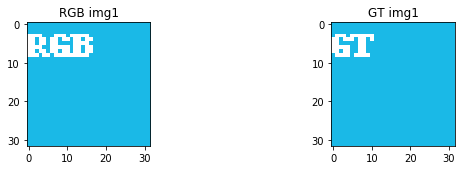

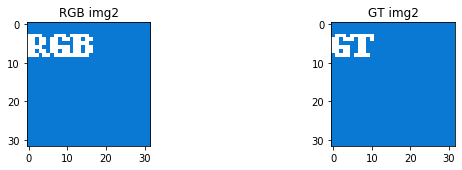

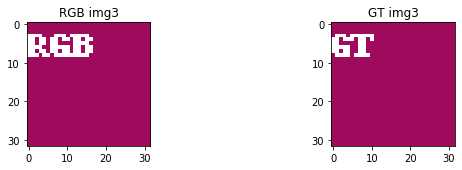

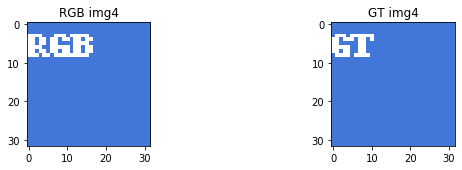

batch 2:


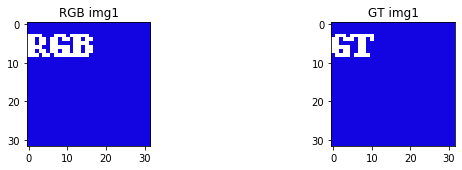

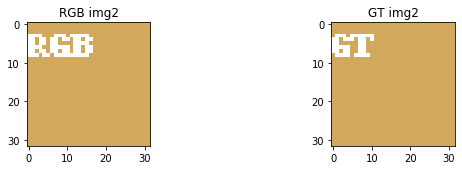

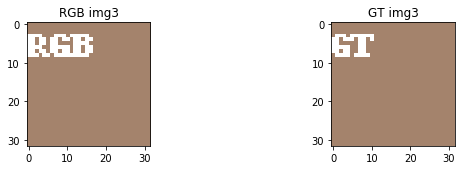

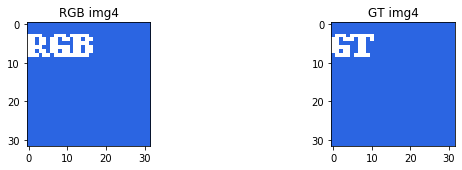

In [6]:
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


bs=4  # batch size
transforms = ToTensor()  # we need this to convert PIL images to Tensor
shuffle = True

dataset = CustomVisionDataset('./data', rgb_transform=transforms, gt_transform=transforms)
dataloader = DataLoader(dataset, batch_size=bs, shuffle=shuffle)

for i, (rgb, gt) in enumerate(dataloader):
    print(f'batch {i+1}:')
    # some plots
    for i in range(bs):
        plt.figure(figsize=(10, 5))
        plt.subplot(221)
        plt.imshow(rgb[i].squeeze().permute(1, 2, 0))
        plt.title(f'RGB img{i+1}')
        plt.subplot(222)
        plt.imshow(gt[i].squeeze().permute(1, 2, 0))
        plt.title(f'GT img{i+1}')
        plt.show()